In [4]:
import os
import pandas as pd

def get_logname(d):
    return os.path.join('old_out/ea_res_small-pool', d, 'log.csv')

bench = 'cifar100'

all_data = [pd.read_csv(get_logname(d)) for d in os.listdir('old_out/ea_res_small-pool') if os.path.exists(get_logname(d)) if bench in d]
all_data = pd.concat(all_data, ignore_index=True)

In [5]:
all_data

,n_exp,T,val_acc,name
0,0,0,70.40,rank: flops filter: snip q: 0.8
1,0,1,70.40,rank: flops filter: snip q: 0.8
2,0,2,70.40,rank: flops filter: snip q: 0.8
3,0,3,71.46,rank: flops filter: snip q: 0.8
4,0,4,71.46,rank: flops filter: snip q: 0.8
...,...,...,...,...
279995,9,495,73.26,rank: flops filter: nwot q: 0.8
279996,9,496,73.26,rank: flops filter: nwot q: 0.8
279997,9,497,73.26,rank: flops filter: nwot q: 0.8
279998,9,498,73.26,rank: flops filter: nwot q: 0.8


In [6]:
import numpy as np

def quant_t(df, t, q):
    return df[df['T'] == t]['val_acc'].quantile(q)

def quant_arr(df, q):
    quants = [quant_t(df, t, q) for t in sorted(df['T'].unique())]
    return np.array(quants)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


def plot_it(ranks, filters, inv=False, save=False):
    ranks = [] if ranks is None else ranks
    filters = [] if filters is None else filters
    if isinstance(ranks, str):
        ranks = [ranks]
    if isinstance(filters, str):
        filters = [filters]

    names = None
    for prox in ['nwot', 'zen', 'synflow', 'flops', 'random']:
        nextnames = all_data['name'].str.contains(prox)
        names = nextnames if names is None else (names | nextnames)
    #.unique()[[6, 7, 14, 12, 16, 21, 28, 29, 30, 33, 36, 40]]
    plot_data = all_data[names].reset_index(drop=True)

    def _get_idx(what, rank_it):
        print(what, rank_it)
        return plot_data['name'].str.contains(f'{"rank" if rank_it else "filter"}: {what}')

    rank_filter = None
    for r in ranks:
        res = _get_idx(r, True)
        rank_filter = res if rank_filter is None else (rank_filter | res)

    filter_filter = None
    for f in filters:
        res = _get_idx(f, False)
        filter_filter = res if filter_filter is None else (filter_filter | res)

    if filter_filter is None:
        filter = rank_filter
    elif rank_filter is None:
        filter = filter_filter
    else:
        assert filter_filter is not None
        filter = rank_filter & filter_filter
    plot_data = plot_data[~filter if inv else filter]

    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=plot_data, x='T', y='val_acc', hue='name', ci=None)

    for prox in plot_data['name'].unique():
        d = plot_data[plot_data['name'] == prox]
        ax.fill_between(d['T'].unique(), quant_arr(d, 0.25), quant_arr(d, 0.75), alpha=0.3)

    plt.xlim(-5, 300)
    plt.ylim(70, 73.5)
    if not save:
        plt.show()

nwot True
zen False
synflow False
nwot False
params False


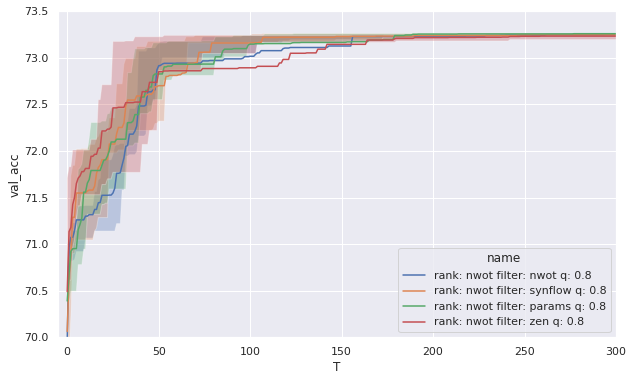

synflow True
params False
zen False
nwot False
synflow False


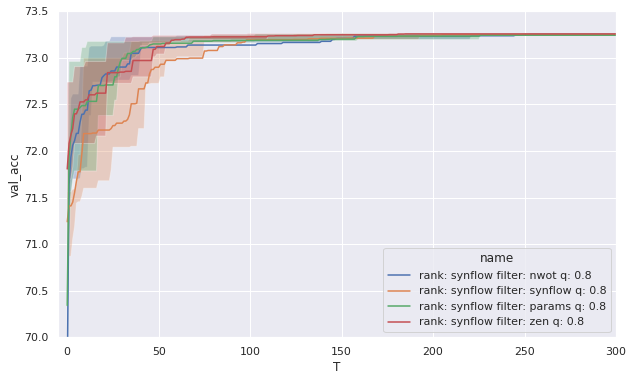

In [24]:
#plot_it('flops', None)#, ['flops', 'random', 'fisher', 'nwot'])
plot_it('nwot', ['zen', 'synflow', 'nwot', 'params'])#, ['nwot', 'random', 'flops', 'fisher'])
plot_it('synflow', ['params', 'zen', 'nwot', 'synflow'])#, ['nwot', 'random', 'flops', 'fisher'])

fisher True
flops True
synflow True
nwot True
None False


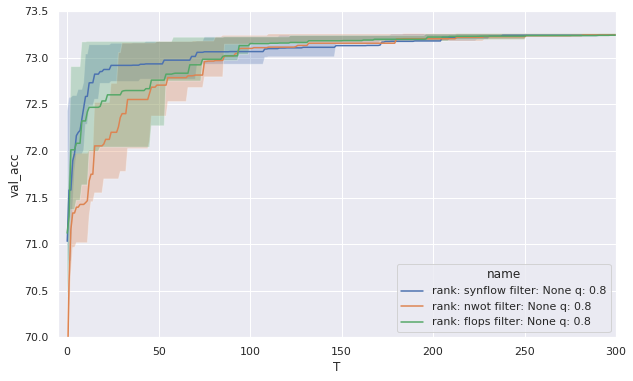

In [9]:
plot_it(['fisher', 'flops', 'synflow', 'nwot'], "None")

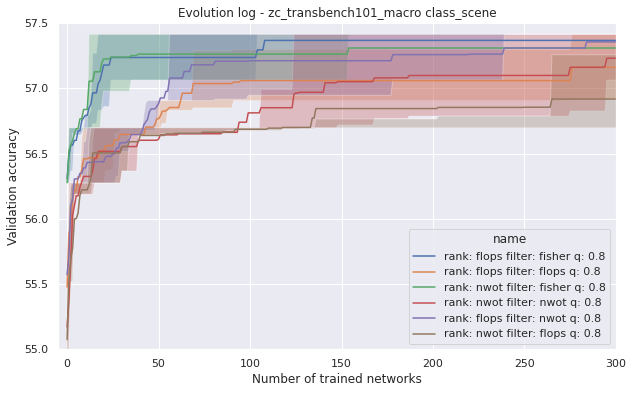

In [169]:
plot_it('random', None, save=True)
plt.title('Evolution log - zc_transbench101_macro class_scene')
plt.xlabel('Number of trained networks')
plt.ylabel('Validation accuracy')
plt.savefig('class_scene')